<a href="https://colab.research.google.com/github/Soumyajit-Chakraborty/Waterbody_segmentation/blob/main/Adaptive_Cuckoo_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimal Thresholds: [101 138]


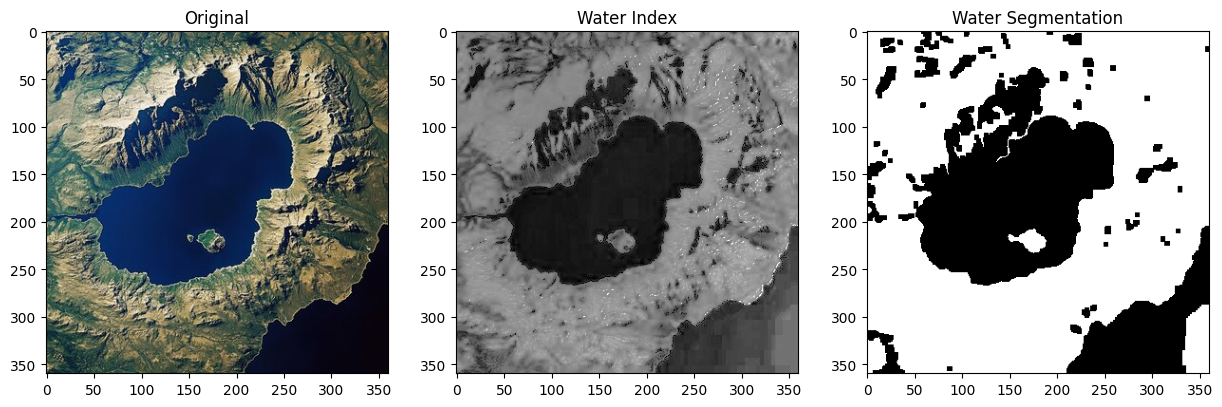

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ===============================
# 1️⃣ WATER INDEX (RGB-based)
# ===============================
def compute_water_index(image):
    B = image[:,:,0].astype(float)
    G = image[:,:,1].astype(float)
    R = image[:,:,2].astype(float)

    wi = (B - R) / (B + R + 1e-10)
    wi_norm = ((wi - wi.min()) / (wi.max() - wi.min()) * 255)
    return wi_norm.astype(np.uint8)


# ===============================
# 2️⃣ TEXTURE MAP (Local Variance)
# ===============================
def compute_texture_map(gray, ksize=5):
    mean = cv2.blur(gray.astype(float), (ksize, ksize))
    sq_mean = cv2.blur((gray.astype(float))**2, (ksize, ksize))
    variance = sq_mean - mean**2
    variance_norm = ((variance - variance.min()) / (variance.max() - variance.min()) * 255)
    return variance_norm.astype(np.uint8)


# ===============================
# 3️⃣ WATER-AWARE FITNESS
# ===============================
def water_fitness(wi, texture, thresholds):
    T_wi, T_tex = thresholds

    # Candidate mask
    mask = (wi > T_wi) & (texture < T_tex)

    if np.sum(mask) == 0:
        return 0

    # Otsu-like separation (between-class variance on WI)
    # Extract segmented regions
    water_pixels = wi[mask]
    non_water_pixels = wi[~mask]

    if len(water_pixels) == 0 or len(non_water_pixels) == 0:
        return 0

    # Compute means
    mu_water = np.mean(water_pixels)
    mu_non_water = np.mean(non_water_pixels)

    # Compute class probabilities
    omega_water = len(water_pixels) / wi.size
    omega_non_water = len(non_water_pixels) / wi.size

    # Compute total mean
    mu_total = omega_water * mu_water + omega_non_water * mu_non_water

    # Between-class variance
    between_var = (
        omega_water * (mu_water - mu_total) ** 2 +
        omega_non_water * (mu_non_water - mu_total) ** 2
    )

    # Spatial continuity (favor large connected regions)
    mask_uint = mask.astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint)

    largest_component = 0
    for i in range(1, num_labels):
        largest_component = max(largest_component, stats[i, cv2.CC_STAT_AREA])

    spatial_score = largest_component / (wi.shape[0] * wi.shape[1])

    # Final fitness (weighted)
    fitness = between_var + 500 * spatial_score

    return fitness


# ===============================
# 4️⃣ 2D ADAPTIVE CUCKOO SEARCH
# ===============================
def ACS_2D(wi, texture, n_nests=25, n_iter=50, pa=0.25):

    nests = np.random.randint(1, 255, (n_nests, 2))
    fitness = np.array([water_fitness(wi, texture, nest) for nest in nests])

    for t in range(1, n_iter+1):

        best = np.max(fitness)
        worst = np.min(fitness)

        for i in range(n_nests):

            step = (1/t) * abs((best - fitness[i]) / (best - worst + 1e-10))

            new_nest = nests[i] + np.random.randn(2) * step * 50
            new_nest = np.clip(new_nest, 1, 254).astype(int)

            new_fitness = water_fitness(wi, texture, new_nest)

            if new_fitness > fitness[i]:
                nests[i] = new_nest
                fitness[i] = new_fitness

        # Abandon some nests
        abandon = np.random.rand(n_nests) < pa
        nests[abandon] = np.random.randint(1, 255, (np.sum(abandon), 2))
        fitness[abandon] = np.array([water_fitness(wi, texture, nest) for nest in nests[abandon]])

    best_index = np.argmax(fitness)
    return nests[best_index]


# ===============================
# 5️⃣ MORPHOLOGICAL CLEANUP
# ===============================
def post_process(mask):

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < 500:
            mask[labels == i] = 0

    return mask


# ===============================
# 6️⃣ RUN FULL PIPELINE
# ===============================
image = cv2.imread("/content/satellite-view-lake-reservoir-featuring-water-body-surrounding-terrain-key-land_1314467-234623.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

wi = compute_water_index(image)
texture = compute_texture_map(gray)

best_thresholds = ACS_2D(wi, texture, n_nests=30, n_iter=60)

T_wi, T_tex = best_thresholds

water_mask = (wi > T_wi) & (texture < T_tex)
water_mask = post_process(water_mask)

print("Optimal Thresholds:", best_thresholds)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image)

plt.subplot(1,3,2)
plt.title("Water Index")
plt.imshow(wi, cmap='gray')

plt.subplot(1,3,3)
plt.title("Water Segmentation")
plt.imshow(water_mask, cmap='gray')

plt.show()